In [1]:
import torch
!pip install monai
from tqdm import tqdm
from statistics import mean
from torch.nn.functional import threshold, normalize
from monai.networks import one_hot
from torchvision.transforms import Resize
import torch.nn.functional as F
!pip install -q git+https://github.com/huggingface/transformers.git datasets


  Using cached monai-1.3.0-202310121228-py3-none-any.whl.metadata (10 kB)
Using cached monai-1.3.0-202310121228-py3-none-any.whl (1.3 MB)


In [2]:
from torch.utils.data import Dataset
from tqdm import tqdm
class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"]).transpose(2,0,1)

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs


def get_bounding_box(ground_truth_map):
    """
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]
    """
    H, W = ground_truth_map.shape[:2]
    bbox = [0, 0, W, H]

    return bbox


### download test data
Same process as for the training data

In [ ]:
#!pip install git+https://github.com/surgical-vision/SAR_RARP50-evaluation#egg=sarrarp50-toolkit

'''
import os
#!pip install wget
#import wget
#url = 'https://rdr.ucl.ac.uk/ndownloader/articles/24932499/versions/1'
#filename = wget.download(url)

##unzip
import zipfile
with zipfile.ZipFile("24932499.zip","r") as zip_ref:
    zip_ref.extractall("test_folder")

for video in os.listdir('test_folder/'):
    if video.endswith(".zip"):
        with zipfile.ZipFile('test_folder/'+video,"r") as zip_ref:
            zip_ref.extractall('test_folder/'+video[:-4])
'''
import sarrarp50
import argparse, sys
from sample_video import sample_video as sample_video_u

def main_sample(args):

    video_fps = 60 # all the sarrarp50 videos are recorded at 60 fps
    sampiling_period:int =video_fps//args.frequency

    # find all the files that need to be processed
    """
    if not args.recursive:
        #video_dirs = [Path(args.data_dir).resolve()]
        video_dirs = [Path('path_to_root_data_dir').resolve()]
    else:
        #video_dirs = [v_p.parent for v_p in Path(args.data_dir).rglob('*video_left.avi')]
        """
    video_dirs = [v_p.parent for v_p in Path('test_folder').rglob('*video_left.avi')]
    # validate paths
    
    for directory in video_dirs:
        if not (directory.exists() and (directory/'video_left.avi').exists()):
            print(f"{directory} does not a video directory. please make sure video directory path is correct")
    
    for directory in video_dirs:#, desc='unpacking dataset', bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
        rgb_dir = (directory/'rgb')
        sample_video_u(directory/'video_left.avi', rgb_dir, sampiling_period, args.jobs)


parser = argparse.ArgumentParser()
parser.add_argument('data_dir', help='path pointing to the video or dataset directory',default='test_folder')
parser.add_argument('-f', '--frequency', type=int, help='sampling rate in Hz', choices= [1, 10], default=1)
parser.add_argument('-r', '--recursive', help='search recursively for video directories that have video_left.avi as a child', action='store_true')
parser.add_argument('-j', '--jobs', help='number of parallel works to use when saving images', default=4, type=int)
args = parser.parse_args(sys.argv[2:])
SystemExit(main_sample(args))


### import model

In [3]:
## data processing loading
import torch
from transformers import SamModel, SamProcessor
from torch.utils.data import DataLoader
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

from torch.optim import Adam
import monai
from transformers import SamModel 
from torch import nn
from fpn.factory import make_fpn_efficientnet

fpn = make_fpn_efficientnet(
	name='efficientnet_b0',
	fpn_type='fpn',
	pretrained=True,
	num_classes=11,
	fpn_channels=128,
	in_channels=4,
	out_size=(256, 256))

sam = SamModel.from_pretrained("facebook/sam-vit-base")

class model_classify(nn.Module):
    def __init__(self, sam,classi):
        super().__init__()
        self.sam = sam
        self.classi = classi
        #self.linear = nn.Linear(3,11)

    def forward(self,pixel_values,input_boxes,multimask_output):
        
        outputs = self.sam(pixel_values = pixel_values,input_boxes = input_boxes,multimask_output = multimask_output)
        outputs_mask = outputs.pred_masks.squeeze(1)
        outputs = F.sigmoid(outputs.pred_masks.squeeze(1))
        z = (outputs>0.5).int()
        mask = (z == 0)
        z = z * (~mask)
        z = torch.concatenate([z , Resize((256,256))(pixel_values)],axis = 1)
        z = self.classi(z)
        '''
        N,C,H,W = predicted_masks.shape
        predicted_masks = predicted_masks.permute(0,2,3,1).contiguous()
        predicted_masks = predicted_masks.reshape(N*H*W,C)
        predicted_masks = self.linear(predicted_masks)
        predicted_masks = predicted_masks.reshape(N,H,W,11)
        predicted_masks = predicted_masks.permute(0,3,1,2).contiguous()
        '''
        return z,outputs_mask
        
model = model_classify(sam, fpn)


checkpoint = torch.load('./sam_classification_3.pt')
model.load_state_dict(checkpoint)

model.to(device)


optimizer = Adam(model.classi.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
seg_loss_class = monai.losses.DiceCELoss( squared_pred=True, reduction='mean')

Using cache found in /home/jovyan/.cache/torch/hub/lukemelas_EfficientNet-PyTorch_master


Loaded pretrained weights for efficientnet-b0


Using cache found in /home/jovyan/.cache/torch/hub/lukemelas_EfficientNet-PyTorch_master


Loaded pretrained weights for efficientnet-b0


### Eval on a few picture picked randomly

In [4]:
#from PIL import Image 
import numpy as np
from pathlib import Path

list_path = [[],[]]
for par in np.unique([v_p.parent.parent for v_p in Path('test_folder').rglob('*.png')]):
    for video in [v_p for v_p in Path(par/'rgb').rglob('*.png')]:
        list_path[0].append(str(video))
        list_path[1].append(str(par/'segmentation'/video.name))
ind = np.random.choice(np.arange(len(list_path[0])), 1000)
list_path[0] = np.array(list_path[0])[list(ind )]
list_path[1] = np.array(list_path[1])[list(ind) ]

In [5]:
from datasets import load_dataset,Dataset, Image
dataset = Dataset.from_dict({'label' : list_path[1],  'image' : list_path[0]}).cast_column("image", Image()).cast_column("label", Image())
#dataset = load_dataset("nielsr/breast-cancer", split="train")

In [6]:
def transforms_image(examples):
    examples["image"] = [image.resize((256,256)) for image in examples["image"]]
    
    return examples

dataset = dataset.map(transforms_image, batched=True)

def transforms_label(examples):
    examples["label"] = [image.resize((256,256)) for image in examples["label"]]
    
    return examples
dataset = dataset.map(transforms_label, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [7]:
## filter applied on pictures
from scipy.ndimage import laplace
from numpy import asarray
from PIL import Image
for ind in range(len(dataset)):
    dataset[ind]['image'] = Image.fromarray(asarray(dataset[ind]['image'])+laplace(asarray(dataset[6]['image'])))


In [8]:
test_dataloader = SAMDataset(dataset=dataset, processor=processor)
test_dataloader = DataLoader(test_dataloader, batch_size=2, shuffle=True)

In [9]:
result = np.zeros((2,len(list_path[0]), 256,256))
device = 'cuda'
model.eval()
with torch.no_grad():

    for i,batch in tqdm(enumerate(test_dataloader)):
  # forward pass
        outputs, __ = model(pixel_values = batch["pixel_values"].to(device),
                  input_boxes = batch["input_boxes"].to(device),
                  multimask_output = False)
        outputs = torch.softmax(outputs, axis = 1)
        outputs = outputs.cpu().numpy().squeeze()
        outputs = np.argmax(outputs, axis = 1).astype(np.uint8)
        result[0, i*2:(i+1)*2] = outputs
        result[1, i*2:(i+1)*2] = batch["ground_truth_mask"].float().mean(axis = 1)
  

0it [00:00, ?it/s]/srv/conda/envs/notebook/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
500it [07:35,  1.10it/s]


### Evaluation 
- We draw some random samples and compare prediction and ground truth
- We compute two geometrical / probabilistic metrics

(-0.5, 255.5, 255.5, -0.5)

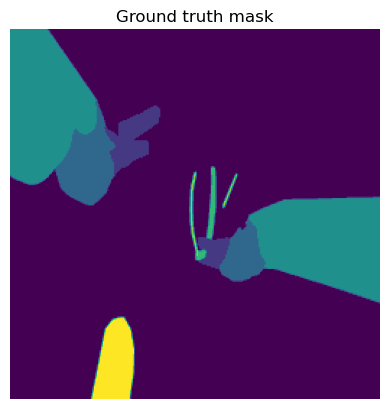

In [10]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
ind_eval = np.random.choice(np.arange(len(dataset)), 1)[0]
axes.imshow(np.array(result[1,ind_eval]))
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

(-0.5, 255.5, 255.5, -0.5)

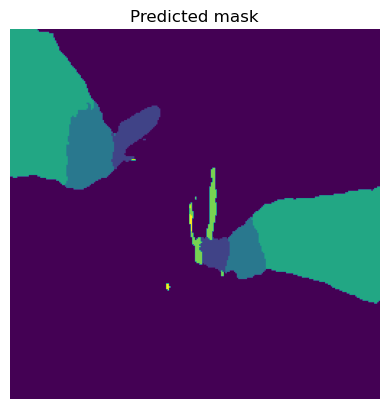

In [11]:
fig, axes = plt.subplots()
axes.imshow(result[0,ind_eval])
axes.title.set_text(f"Predicted mask")
axes.axis("off")

#### Surface Dice Metric

In [27]:
metric = monai.metrics.SurfaceDiceMetric([1]*11,
                                            include_background=True,
                                            reduction='mean')
truth = one_hot(torch.Tensor(result[1])[:,None,...], num_classes = 11)
pred = one_hot(torch.Tensor(result[0])[:,None,...],num_classes = 11)

met = metric(truth,pred)
met[met.isnan()] = 1
met.mean(axis = 1).mean()


tensor(0.4203)

#### Mean Intersection over Union Metric

In [12]:
metric = monai.metrics.MeanIoU(include_background=True, reduction='mean', get_not_nans=False, ignore_empty=False)
truth = one_hot(torch.Tensor(result[1])[:,None,...], num_classes = 11)
pred = one_hot(torch.Tensor(result[0])[:,None,...],num_classes = 11)

met = metric(truth,pred)
met.mean()

tensor(0.4872)